In [1]:
DATA = '/archive/bioinformatics/DLLab/KevinNguyen/data/melanoma/filtered/data_train.csv'
# LATENTS = '/archive/bioinformatics/DLLab/KevinNguyen/results/MEDL/melanoma_autoencoder_filtered_20210121/latent_reps_train.npy'
LATENTS = '/archive/bioinformatics/DLLab/KevinNguyen/results/MEDL/melanoma_me_autoencoder_filtered_20210121/random_slope_int/latent_reps_epoch180_train.npy'

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import umap

In [3]:
# Figure labels for each PDX and day
dictPDX = {'m481': 'PDX 1 (High ME)',
           'm634': 'PDX 2 (High ME)',
           'm498': 'PDX 3 (Low ME)',
           'm610': 'PDX 4 (Low ME)'}
dictDates = {'160802': 'Day 1',
             '160808': 'Day 2',
             '161209': 'Day 3',
             '161214': 'Day 4',
             '161220': 'Day 5',
             '161224': 'Day 6'}

In [4]:
dfData = pd.read_csv(DATA, index_col=0)
dfData.reset_index(inplace=True, drop=True)
dfData['date'] = dfData['date'].apply(lambda x: dictDates[str(x)])
dfData['celltype'] = dfData['celltype'].apply(lambda x: dictPDX[x])
arrLatent = np.load(LATENTS)

In [5]:
dfData

date         celltype                                  cell  \
0     Day 1  PDX 1 (High ME)  160802_m481_s04_t60_x2093_y1256_t240   
1     Day 1  PDX 1 (High ME)    160802_m481_s02_t60_x515_y767_t240   
2     Day 1  PDX 1 (High ME)  160802_m481_s03_t60_x1978_y1419_t240   
3     Day 1  PDX 1 (High ME)   160802_m481_s04_t60_x1019_y714_t240   
4     Day 1  PDX 1 (High ME)  160802_m481_s03_t60_x1548_y1303_t240   
...     ...              ...                                   ...   
7383  Day 6   PDX 4 (Low ME)  161224_m610_s14_t60_x1771_y1212_t240   
7384  Day 6   PDX 4 (Low ME)  161224_m610_s14_t60_x2249_y1323_t240   
7385  Day 6   PDX 4 (Low ME)  161224_m610_s11_t60_x1483_y1256_t240   
7386  Day 6   PDX 4 (Low ME)  161224_m610_s14_t60_x2249_y1323_t240   
7387  Day 6   PDX 4 (Low ME)  161224_m610_s14_t60_x1163_y1907_t240   

                                                  image met-eff  
0     /archive/bioinformatics/DLLab/KevinNguyen/data...    high  
1     /archive/bioinformatics/DLLab/KevinNguyen/data...    high  
2     /archive/bioinformatics/DLLab/KevinNguyen/data...    high  
3     /archive/bioinformatics/DLLab/KevinNguyen/data...    high  
4     /archive/bioinformatics/DLLab/KevinNguyen/data...    high  
...                                                 ...     ...  
7383  /archive/bioinformatics/DLLab/KevinNguyen/data...     low  
7384  /archive/bioinformatics/DLLab/KevinNguyen/data...     low  
7385  /archive/bioinformatics/DLLab/KevinNguyen/data...     low  
7386  /archive/bioinformatics/DLLab/KevinNguyen/data...     low  
7387  /archive/bioinformatics/DLLab/KevinNguyen/data...     low  

[7388 rows x 5 columns]

In [6]:
def kl_div(p, q):
    # KL divergence for multivariate distributions based on
    # https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/ 
    pMean = p.mean(axis=0).reshape((-1, 1))
    qMean = q.mean(axis=0).reshape((-1, 1))
    pVar = np.cov(p.T)
    qVar = np.cov(q.T)
    k = p.shape[1]
    qVarInv = np.linalg.inv(qVar)
    kl = 0.5 * (np.log(np.linalg.det(qVar) / np.linalg.det(pVar)) - k + (pMean - qMean).T @ qVarInv @ (pMean - qMean) + np.trace(qVarInv @ pVar))
    return kl.squeeze().item()

KL Divergence between different days, for the same PDX. 

Note that the empty cells in the heatmap occur due to some of the covariance matrices having a negative determinant.

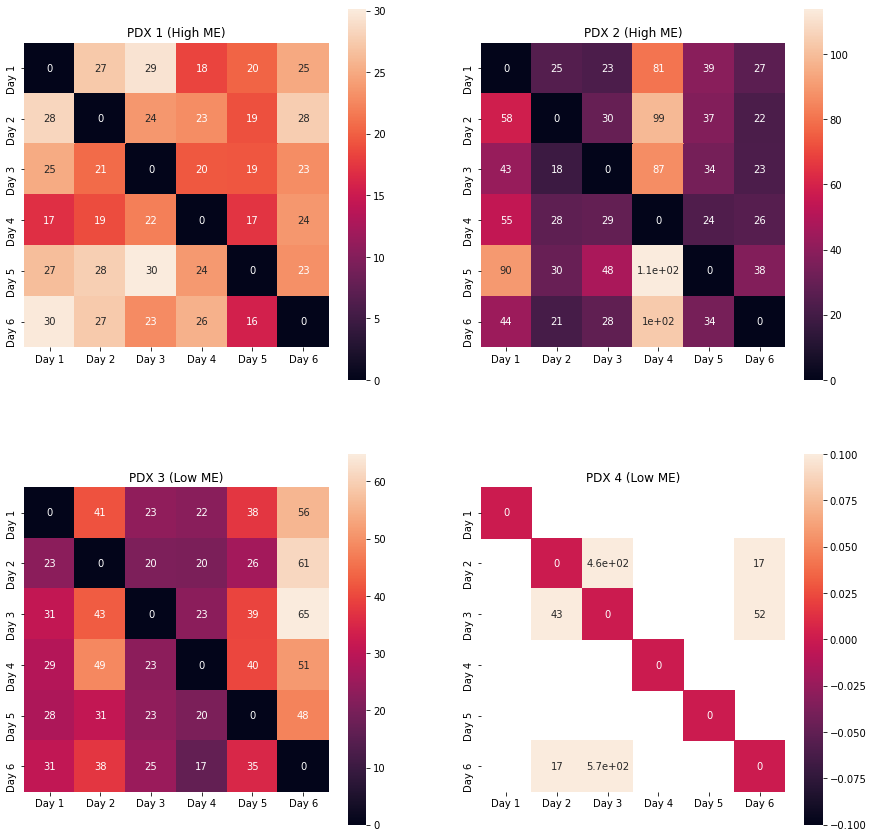

In [7]:
arrCellTypes = dfData['celltype'].unique()
arrCellTypes.sort()

arrDates = dfData['date'].unique()
arrDates.sort()

lsKLLong = []

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
i = 0
for strCellType in arrCellTypes:
    dfKL = pd.DataFrame(index=arrDates, columns=arrDates)
    for iDate0 in arrDates:
        for iDate1 in arrDates:
            if iDate0 == iDate1:
                dfKL.loc[iDate0, iDate1] = 0
            else:
                arrLatent0 = arrLatent[(dfData['date'] == iDate0) & (dfData['celltype'] == strCellType)]
                arrLatent1 = arrLatent[(dfData['date'] == iDate1) & (dfData['celltype'] == strCellType)]
                dfKL.loc[iDate0, iDate1] = kl_div(arrLatent0, arrLatent1)

    sns.heatmap(data=dfKL.astype('float'), ax=ax.flatten()[i], vmin=0, square=True, annot=True)
    ax.flatten()[i].set_title(strCellType)
    i += 1

    dfKLLong = dfKL.melt(value_name='KL divergence')
    dfKLLong = dfKLLong.loc[dfKLLong['KL divergence'] != 0]
    dfKLLong['Group'] = strCellType
    dfKLLong['Comparison'] = 'Intra-PDX'
    lsKLLong += [dfKLLong]


KL Divergence between different cells, same day

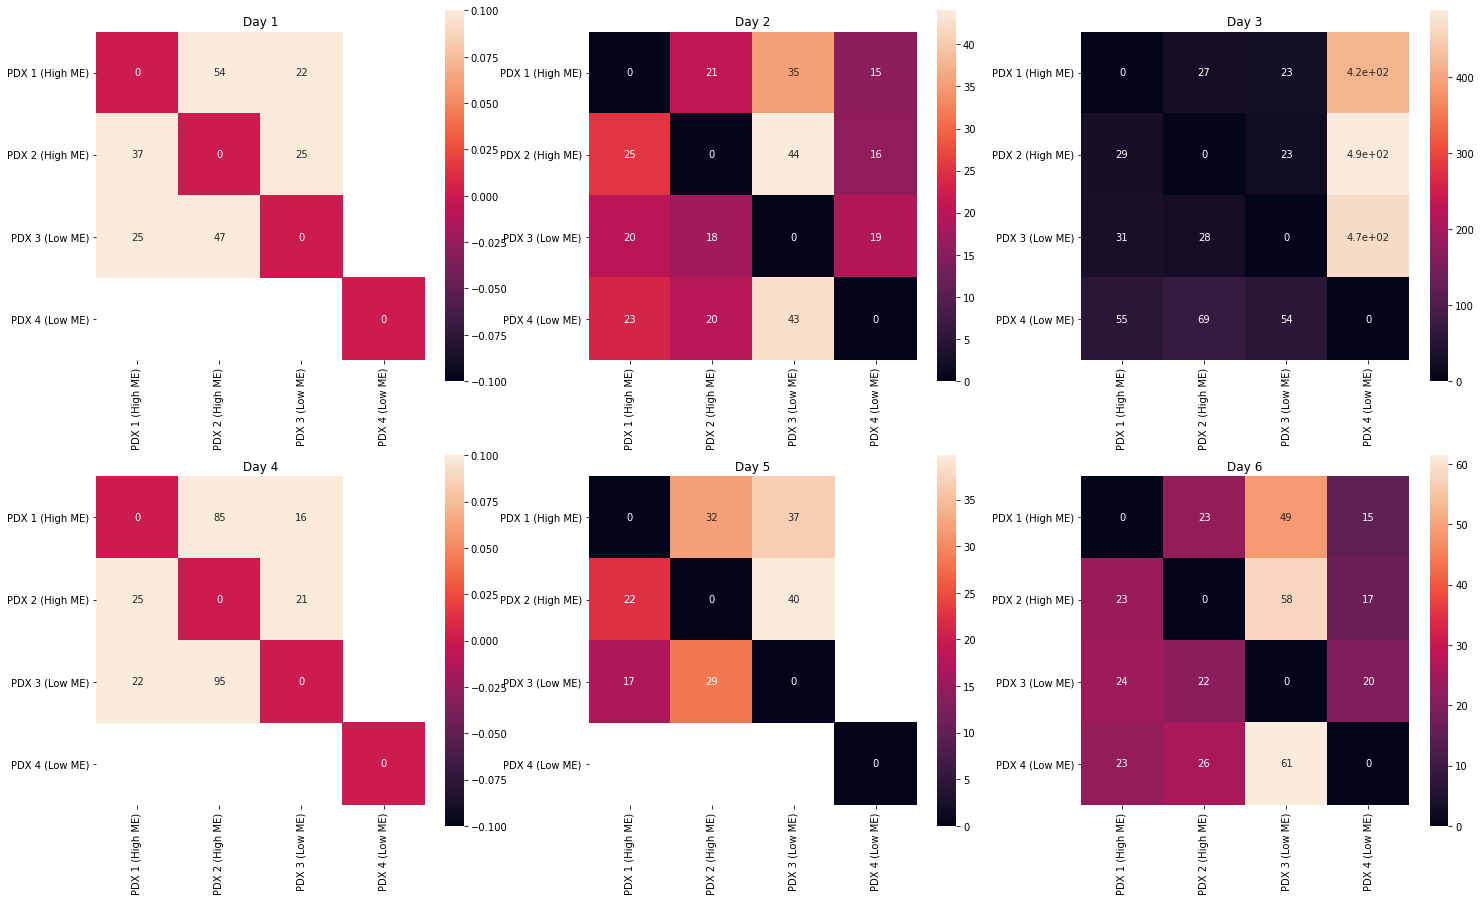

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
i = 0
for iDate in arrDates:
    dfKL = pd.DataFrame(index=arrCellTypes, columns=arrCellTypes)
    for strCellType0 in arrCellTypes:
        for strCellType1 in arrCellTypes:
            if strCellType0 == strCellType1:
                dfKL.loc[strCellType0, strCellType1] = 0
            else:
                arrLatent0 = arrLatent[(dfData['date'] == iDate) & (dfData['celltype'] == strCellType0)]
                arrLatent1 = arrLatent[(dfData['date'] == iDate) & (dfData['celltype'] == strCellType1)]
                dfKL.loc[strCellType0, strCellType1] = kl_div(arrLatent0, arrLatent1)

    sns.heatmap(data=dfKL.astype('float'), ax=ax.flatten()[i], vmin=0, square=True, annot=True)
    ax.flatten()[i].set_title(iDate)
    i += 1

    dfKLLong = dfKL.melt(value_name='KL divergence')
    dfKLLong = dfKLLong.loc[dfKLLong['KL divergence'] != 0]
    dfKLLong['Group'] = str(iDate)
    dfKLLong['Comparison'] = 'Inter-PDX'
    lsKLLong += [dfKLLong]


Plot the median KL divergence for the intra-PDX and inter-PDX comparisons

(10.0, 100.0)

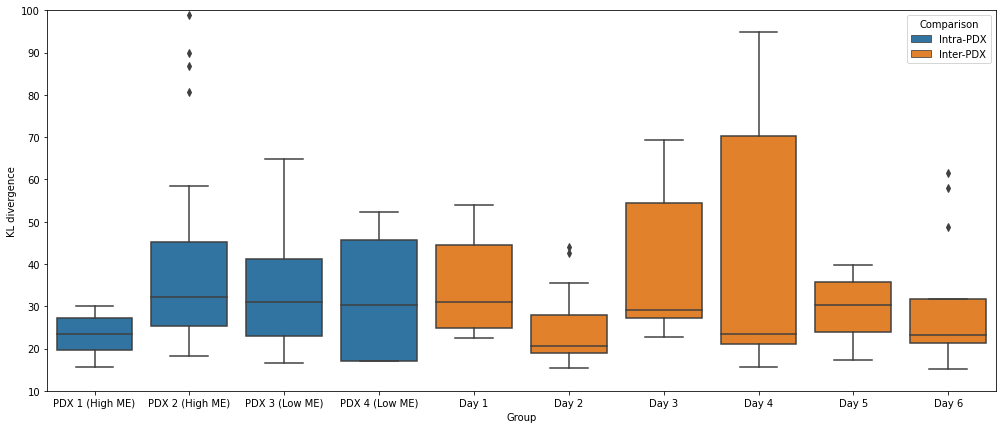

In [9]:
fig, ax = plt.subplots(figsize=(17, 7))
dfKLLong = pd.concat(lsKLLong, axis=0)
# There are some crazy outliers due to numerical problems with calculating the KL divergence
dfKLLong = dfKLLong.loc[dfKLLong['KL divergence'] < 100]
dfKLLong = dfKLLong.loc[dfKLLong['KL divergence'] > -100]
sns.boxplot(data=dfKLLong, x='Group', y='KL divergence', hue='Comparison', ax=ax, dodge=False)
ax.set_ylim(10, 100)

Compute mean latent vectors (across frames) per individual cell, then compute Euclidean distances
- Between cells of the same PDX, across different days
- Between cells of different PDXs, on the same day

In [10]:
dfLatent = pd.DataFrame(arrLatent)
dfLatent = dfLatent.join(dfData)

def mean_str(col):
    # Calculates the mean if values are numeric or the string if values are strings
    if pd.api.types.is_numeric_dtype(col):
        return col.mean()
    else:
        return col.unique() if col.nunique() == 1 else np.nan

dfDistances = pd.DataFrame(columns=['PDX', 'Other PDX', 'Date0', 'Date1', 'Intra-PDX', 'Inter-PDX'])
i = 0
for strCellType0 in arrCellTypes:
    dfLatentPDX = dfLatent.loc[dfLatent['celltype'] == strCellType0]
    # Compute mean latent vector (across frames) for each cell
    dfLatentPDX = dfLatentPDX.groupby('cell').agg(mean_str)

    for iDate0 in arrDates:
        dfDate0 = dfLatentPDX.loc[dfLatentPDX['date'] == iDate0]
        dfDate0 = dfDate0[range(56)]
        for iDate1 in arrDates:
            if iDate1 == iDate0:
                continue
            # Compute pairwise distances between each cell in date0 and each cell of the same PDX in date1
            dfDate1 = dfLatentPDX.loc[dfLatentPDX['date'] == iDate1]
            dfDate1 = dfDate1[range(56)]
            arrDistIntraPDX = scipy.spatial.distance.cdist(dfDate0, dfDate1, metric='euclidean')
            fDistIntraPDX = np.mean(arrDistIntraPDX[np.triu_indices_from(arrDistIntraPDX, k=1)])

            for strCellType1 in arrCellTypes:
                if strCellType1 == strCellType0:
                    continue
                # Compute pairwise distances between each cell of this PDX and each cell other PDXs on the same date
                dfOtherPDX = dfLatent.loc[(dfLatent['celltype'] == strCellType1) & (dfLatent['date'] == iDate0)]
                # Compute mean latent vector across frames for each cell
                dfOtherPDX = dfOtherPDX.groupby('cell').agg(mean_str)
                dfOtherPDX = dfOtherPDX[range(56)]
                arrDistInterPDX = scipy.spatial.distance.cdist(dfDate0, dfOtherPDX, metric='euclidean')

                fDistInterPDX = np.mean(arrDistInterPDX[np.triu_indices_from(arrDistInterPDX, k=1)])
                dfDistances.loc[i] = [strCellType0, strCellType1, iDate0, iDate1, fDistIntraPDX, fDistInterPDX]
                i += 1
       

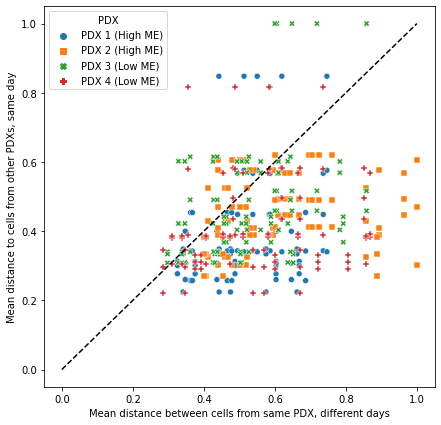

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
dictMarkers = {'PDX 1 (High ME)': 'o',
               'PDX 2 (High ME)': 's',
               'PDX 3 (Low ME)': 'X',
               'PDX 4 (Low ME)': 'P'}
dfDistancesNorm = dfDistances.copy()
dfDistancesNorm[['Intra-PDX', 'Inter-PDX']] /= dfDistancesNorm[['Intra-PDX', 'Inter-PDX']].max()
sns.scatterplot(data=dfDistancesNorm, x='Intra-PDX', y='Inter-PDX', hue='PDX', style='PDX', markers=dictMarkers, ax=ax)
ax.set_xlabel('Mean distance between cells from same PDX, different days')
ax.set_ylabel('Mean distance to cells from other PDXs, same day')
ax.plot([0, 1], [0, 1], 'k--')

Project the latent vectors into a 2-D space with UMAP

In [12]:
scaler = StandardScaler()
arrLatentScaled = scaler.fit_transform(dfLatent[range(56)])
umapper = umap.UMAP(n_components=2, random_state=88, min_dist=0.5)
# dfLatentCellMeans = dfLatent.groupby('cell').agg(mean_str)
arrUmap = umapper.fit_transform(arrLatentScaled)


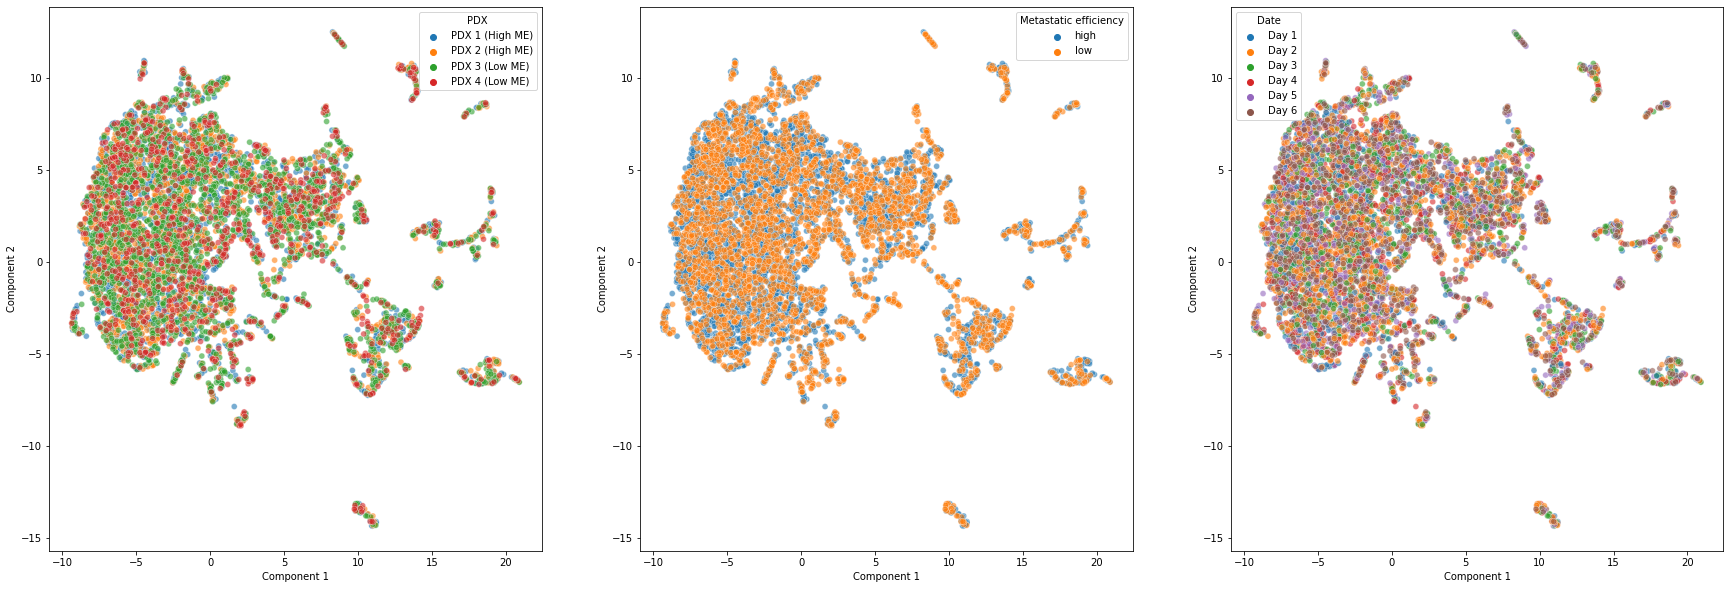

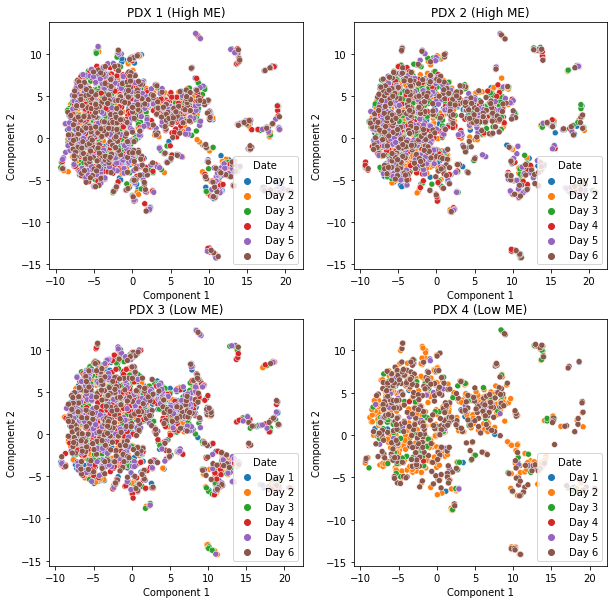

In [13]:
dfUmap = pd.DataFrame(arrUmap, columns=['Component 1', 'Component 2'])
dfUmap['PDX'] = dfLatent['celltype'].values
dfUmap['Metastatic efficiency'] = dfLatent['met-eff'].values
dfUmap['Date'] = dfLatent['date'].values.astype(str)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.scatterplot(data=dfUmap, x='Component 1', y='Component 2', hue='PDX', ax=ax[0], alpha=0.6)
sns.scatterplot(data=dfUmap, x='Component 1', y='Component 2', hue='Metastatic efficiency', ax=ax[1], alpha=0.6)
sns.scatterplot(data=dfUmap, x='Component 1', y='Component 2', hue='Date', ax=ax[2], alpha=0.6)

fig2, ax2 = plt.subplots(2, 2, figsize=(10, 10))
for i, strCellType in enumerate(dfUmap['PDX'].unique()):
    dfCell = dfUmap.loc[dfUmap['PDX'] == strCellType]
    sns.scatterplot(data=dfCell, x='Component 1', y='Component 2', hue='Date', ax=ax2[int(i >= 2), i % 2])
    ax2[int(i >= 2), i % 2].set_title(strCellType)

Compute some clustering metrics to measure separability of the days in the UMAP projection.
- Calinski Harabasz score measures the ratio of between-cluster dispersion to within-cluster dispersion, where dispersion is the sum of squared distances. Higher indicates stronger clustering.
- Silhouette score is bounded \[-1, 1\] with negative values indicating that points are closer to other clusters than their assigned cluster.
- Davies Bouldin score is the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances

In [14]:
print('Calinski Harabasz score', calinski_harabasz_score(dfUmap[['Component 1', 'Component 2']], dfUmap['Date']))
print('Silhouette score', silhouette_score(dfUmap[['Component 1', 'Component 2']], dfUmap['Date']))
print('Davies Bouldin score', davies_bouldin_score(dfUmap[['Component 1', 'Component 2']], dfUmap['Date']))

Calinski Harabasz score 0.3756584660559669
Silhouette score -0.013828602
Davies Bouldin score 208.23784534754373
